# Introducing Supriya

A Python API for SuperCollider

https://github.com/josiah-wolf-oberholtzer/supriya

## Supriya lets you...

- boot and communicate with SuperCollider's `scsynth` synthesis server

- construct and compile SynthDef unit generator graphs in native Python code

- build and control graphs of synthesizers and synthesizer groups

- explicitly object-model `scsynth`-specific OSC commands  via `Request` and `Response` classes

- compile non-realtime synthesis scores via Supriya's `Session` class

- write patterns for realtime or non-realtime synthesis

A lot of the same stuff you do with `sclang` and `scide`, just in Python instead.

## About the author

- A composer and programmer
  - https://github.com/josiah-wolf-oberholtzer
  - https://soundcloud.com/josiah-wolf-oberholtzer/in-the-tall-grasses

- PhD from Harvard in Music Composition, specializing in massively multi-channel tape music and symbolic computer-assisted composition

- Core contributor to Abjad (https://http://abjad.mbrsi.org/), a Python API for LilyPond

- Software engineering manager at Capital One, running a group developing serverless machine learning applications for hotel reservation arbitrage

- Used / taught enough Max/MSP to hit a wall

## Hold up, what's Python? (Cribbed from Wikipedia)

- Python is an interpreted, high-level, general-purpose programming language.

- Created by Guido van Rossum and first released in 1991, **Python has a design philosophy that emphasizes code readability, notably using significant whitespace.** (emphasis mine)

- It provides constructs that enable clear programming on both small and large scales.

- Python features a dynamic type system and automatic memory management.

- It supports multiple programming paradigms, including object-oriented, imperative, functional and procedural, and has a large and comprehensive standard library. It also has a vibrant third-party package ecosystem.

- It's used extensively by the scientific community and companies like Google, Facebook, Instagram (now Facebook lmao), Spotify, Netflix, Dropbox (GvR's employer), Reddit, Microsoft, etc. many of which contribute back to it.

## Hello Python

This is maybe a little corny, but it's pretty good advice.

In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## SuperCollider Architecture Review

- `scsynth`: a synthesis server
- `sclang`: a programming language / interpreter
- `scide`: a GUI for running all of the above
- `OSC (Open Sound Control)`: "a protocol for communication among computers, sound synthesizers, and other multimedia devices"

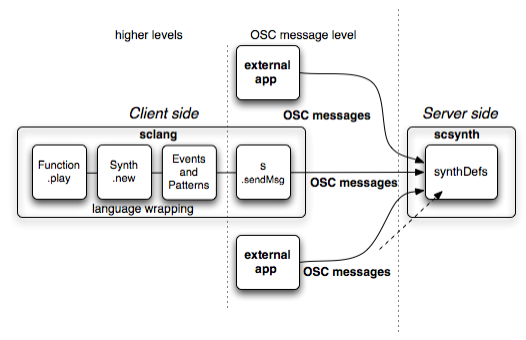

## OK, but why make another `scsynth` client?

- To take advantage of language features and libraries not available in `sclang`
- To explore language features and libraries in your chosen language you might not otherwise interact with
- To better understand how `sclang` and `scsynth` interact
- Just For Fun™
- Because you're stubborn

## No, really, why?

Well, I want...

- To make massively multichannel fixed media pieces in my preferred language, so I can make use of code I've already written as well as many third-party libraries I love using for documentation, testing, etc.
- To have all audio materials modeled in code
- To create parity between the experiences of realtime experimentation and non-realtime composing
- To allow layers of NRT material to reference one another in an object-oriented way
- To allow for fully-reproducible (re-)rendering of NRT scores
- To allow entire scores and related CLI/TUI tools to be fully tested as code

## Some design principles

- Keep the scope narrow / don't reinvent
    - Lean on the wider community for unit test, math, MIDI, etc.
- Keep the interfaces familiar
    - Python makes it easy for classes to implement list-like / dictionary-like interfaces
- Keep the interfaces simple
    - Avoid convenience methods, alternate spellings
- Avoid global state
- Make classes as immutable as possible
    - Local state can be as hard to manage as global state
    - Use factory classes to configure and instantiate instances
- If it's a term-of-art in `scsynth`, use the name

## Hello World

In [2]:
from supriya import Server, Synth

In [3]:
server = Server()
server.boot()

<Server: udp://127.0.0.1:57751, 8i8o>

In [4]:
synth = Synth()
synth.allocate()

<+ Synth: 1000>

In [5]:
print(server)

NODE TREE 0 group
    1 group
        1000 default
            out: 0.0, amplitude: 0.1, frequency: 440.0, gate: 1.0, pan: 0.5


In [6]:
synth.release()

<+ Synth: 1000>

In [7]:
server.quit()

<Server: offline>

### Hello World (a little more complicated)

In [8]:
from supriya import Bus, Group, Server, Synth

In [9]:
server = Server().boot()

In [10]:
bus = Bus.control().allocate()
bus.set(0.5)

In [11]:
group = Group().allocate()
for i in range(1, 10):
    synth = Synth(amplitude=bus, frequency=111 * i)
    _ = synth.allocate(target_node=group)

In [12]:
bus.set(0.1)

In [13]:
group.controls["gate"] = 0

In [14]:
server.quit()

<Server: offline>

## Realtime Server Node Tree Model

Let's just import `supriya`:

In [15]:
import supriya

And let's make a bunch of synths and groups...

In [16]:
synth_a = supriya.Synth(frequency=333, name="A")
synth_b = supriya.Synth(frequency=444, name="B")
synth_c = supriya.Synth(frequency=555, name="C")
outer_group = supriya.Group(name="Outer")
inner_group = supriya.Group(name="Inner")
outer_group.extend([synth_a, inner_group, synth_c])
inner_group.append(synth_b)

Shhh, this is magic...

In [17]:
%load_ext supriya.ext.ipython

...so we can capture some of Supriya's output in this presentation:

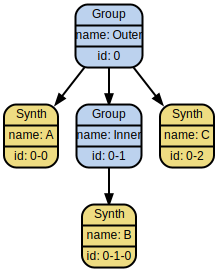

In [18]:
_ = supriya.graph(outer_group)

Groups know about their children and nodes know about their parents:

In [19]:
for index, node in enumerate(outer_group.children):
    print(index, repr(node)) 

0 <- Synth: ??? (A)>
1 <- Group: ??? (Inner)>
2 <- Synth: ??? (C)>


In [20]:
for distance, node in enumerate(synth_b.parentage):
    print(distance, repr(node))

0 <- Synth: ??? (B)>
1 <- Group: ??? (Inner)>
2 <- Group: ??? (Outer)>


Nodes can be iterated depth-first and know their position in the tree:

In [21]:
for child in outer_group.depth_first():
    print(repr(child), child.graph_order)

<- Synth: ??? (A)> (0,)
<- Group: ??? (Inner)> (1,)
<- Synth: ??? (B)> (1, 0)
<- Synth: ??? (C)> (2,)


Booting the server is "just like"™ in `sclang`:

In [22]:
server = supriya.Server()
server.boot()

<Server: udp://127.0.0.1:57751, 8i8o>

We can print out to the interpreter a string representation of `scsynth`'s state:

In [23]:
print(server)

NODE TREE 0 group
    1 group


Allocating a group recursively allocates its children. 

In [24]:
outer_group.allocate()
print(server)

NODE TREE 0 group
    1 group
        1000 group
            1001 default
                out: 0.0, amplitude: 0.1, frequency: 333.0, gate: 1.0, pan: 0.5
            1002 group
                1003 default
                    out: 0.0, amplitude: 0.1, frequency: 444.0, gate: 1.0, pan: 0.5
            1004 default
                out: 0.0, amplitude: 0.1, frequency: 555.0, gate: 1.0, pan: 0.5


Let's visualize the allocated node structure:

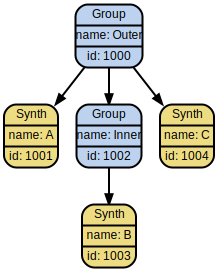

In [25]:
_ = supriya.graph(outer_group)

We can query synth controls and set them like a Python dictionaryL

In [26]:
synth_a["frequency"]

333.0

In [27]:
synth_a["frequency"] = 654
print(synth_a["frequency"])

654.0


And we can set the controls of synths who are members of the subtree rooted at some group by setting a key of that the group like you would a dictionary 🧐:

In [28]:
outer_group.controls["amplitude"] = 0.01
synth_a["amplitude"]

0.01

The synth controls are also explicitly modeled, hidden inside the "controls" interface:

In [29]:
for control_name in synth_a.controls:
    print(repr(synth_a.controls[control_name]))

<SynthControl: <+ Synth: 1001 (A)> "amplitude": 0.01 [kr]>
<SynthControl: <+ Synth: 1001 (A)> "frequency": 654.0 [kr]>
<SynthControl: <+ Synth: 1001 (A)> "gate": 1.0 [kr]>
<SynthControl: <+ Synth: 1001 (A)> "out": 0.0 [ir]>
<SynthControl: <+ Synth: 1001 (A)> "pan": 0.5 [kr]>


Groups also have a control interface, aggregating controls from synths in their subtree:

In [30]:
for control_name in outer_group.controls:
    print(repr(outer_group.controls[control_name]))

<GroupControl: <+ Group: 1000 (Outer)> "amplitude" [kr]>
<GroupControl: <+ Group: 1000 (Outer)> "frequency" [kr]>
<GroupControl: <+ Group: 1000 (Outer)> "gate" [kr]>
<GroupControl: <+ Group: 1000 (Outer)> "out" [ir]>
<GroupControl: <+ Group: 1000 (Outer)> "pan" [kr]>


We can allocate new nodes and move existing nodes in the same command

In [31]:
synth_d = supriya.Synth(synthdef=supriya.assets.synthdefs.pad, name="D ")
inner_group.extend([synth_d, synth_a])

Iteration continues to work 😂:

In [32]:
for node in outer_group.children:
    print(repr(node))

<+ Group: 1002 (Inner)>
<+ Synth: 1004 (C)>


And the `Outer` group now knows about a new synth control name from the `pad` SynthDef:

In [33]:
for control_name in outer_group.controls:
    print(control_name)

amplitude
filter_frequency
frequency
gate
out
pan


We can visualize the entire server node structure, including the root node and default group:

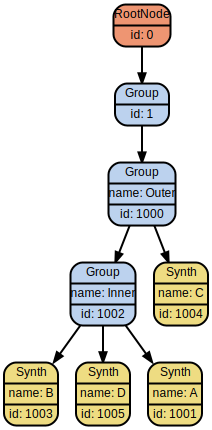

In [34]:
_ = supriya.graph(server)

Let's free the `Outer` group:

In [35]:
outer_group.free()

<- Group: ??? (Outer)>

In [36]:
print(server)

NODE TREE 0 group
    1 group


Explicitly freeing a group does not destructure its children:

In [37]:
print(outer_group)

??? group (Outer)
    ??? group (Inner)
        ??? default (B)
            amplitude: 0.01, frequency: 444.0, gate: 1.0, out: 0.0, pan: 0.5
        ??? pad (D )
            amplitude: 0.1, filter_frequency: 1500.0, frequency: 440.0, gate: 1.0, out: 0.0, pan: 0.0
        ??? default (A)
            amplitude: 0.01, frequency: 654.0, gate: 1.0, out: 0.0, pan: 0.5
    ??? default (C)
        amplitude: 0.01, frequency: 555.0, gate: 1.0, out: 0.0, pan: 0.5


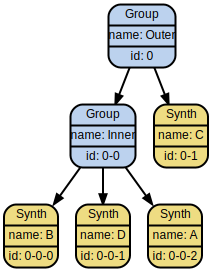

In [38]:
_ = supriya.graph(outer_group)

In [39]:
server.quit()

<Server: offline>

## OSC Command Aggregation

What's Supriya _actually_ doing when we move nodes in and out of the server tree?

In [40]:
server = supriya.Server().reboot()
server.debug_request_names = True  # for legibility

Here's the same node structure as before...

In [41]:
synth_a = supriya.Synth(frequency=333, name="A")
synth_b = supriya.Synth(frequency=444, name="B")
synth_c = supriya.Synth(frequency=555, name="C")
outer_group = supriya.Group(name="Outer")
inner_group = supriya.Group(name="Inner")
outer_group.extend([synth_a, inner_group, synth_c])
inner_group.append(synth_b)
print(outer_group)

??? group (Outer)
    ??? default (A)
        amplitude: 0.1, frequency: 333.0, gate: 1.0, out: 0.0, pan: 0.5
    ??? group (Inner)
        ??? default (B)
            amplitude: 0.1, frequency: 444.0, gate: 1.0, out: 0.0, pan: 0.5
    ??? default (C)
        amplitude: 0.1, frequency: 555.0, gate: 1.0, out: 0.0, pan: 0.5


Let's allocate the default SynthDef manually (why?):

In [42]:
supriya.assets.synthdefs.default.allocate()

<SynthDef: default>

We can spy on OSC messages going to and coming from `scsynth`:

In [43]:
with server.osc_io.capture() as transcript:
    outer_group.allocate()

In [44]:
for timestamp, osc_message in transcript.sent_messages:
    print(repr(osc_message))

OscBundle(
    contents=(
        OscMessage('/g_new', 1000, 0, 1),
        OscMessage('/s_new', 'default', 1001, 0, 1000, 'frequency', 333.0),
        OscMessage('/g_new', 1002, 3, 1001),
        OscMessage('/s_new', 'default', 1003, 0, 1002, 'frequency', 444.0),
        OscMessage('/s_new', 'default', 1004, 3, 1002, 'frequency', 555.0),
        OscMessage('/sync', 0),
        ),
    )


- What was sent when we allocated that group? An OSC bundle.
- What's an OSC bundle? A bunch of OSC messages meant to execute simultaneously.
- Supriya models OSC bundles and OSC messages explicitly as classes
- The OSC messages here are a linearized version of depth-first allocation of the nodes in the subtree.

We also have the responses from the server to each of those `/s_new` and `/g_new` commands.
And the `/synced` response as well...

In [45]:
for timestamp, osc_message in transcript.received_messages:
    print(repr(osc_message))

OscMessage('/n_go', 1000, 1, -1, -1, 1, -1, -1)
OscMessage('/n_go', 1001, 1000, -1, -1, 0)
OscMessage('/n_go', 1002, 1000, 1001, -1, 1, -1, -1)
OscMessage('/n_go', 1003, 1002, -1, -1, 0)
OscMessage('/n_go', 1004, 1000, 1002, -1, 0)
OscMessage('/synced', 0)


Recall that I manually allocated the default synthdef earlier.

Let's make a new synth_d using a simple sine-wave synthdef.

Let's allocate the new synth and also move synth 1001 into the inner group.

In [46]:
synth_d = supriya.Synth(synthdef=supriya.assets.synthdefs.simple_sine)
with server.osc_io.capture() as transcript:
    inner_group.extend([synth_d, synth_a])

Supriya knows if synthdefs have previously been allocated.

When allocating new synths it will generate an `/d_recv` and add any node allocation / movement / free commands as the completion message:

In [47]:
for timestamp, osc_message in transcript.sent_messages:
    print(repr(osc_message))

OscMessage('/d_recv', bytearray(b'SCgf\x00\x00\x00\x02\x00\x01\x0bsimple_sine\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00C\xdc\x00\x00\x00\x00\x00\x03\tamplitude\x00\x00\x00\x00\x03bus\x00\x00\x00\x01\tfrequency\x00\x00\x00\x02\x00\x00\x00\x04\x07Control\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x01\x01\x01\x06SinOsc\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x00\x02\x0cBinaryOpUGen\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03Out\x02\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00'), OscBundle(
    contents=(
        OscMessage('/s_new', 'simple_sine', 1005, 3, 1003),
        OscMessage('/n_after', 1001, 1005),
        ),
    ))


In [48]:
for timestamp, osc_message in transcript.received_messages:
    print(repr(osc_message))

OscMessage('/n_go', 1005, 1002, 1003, -1, 0)
OscMessage('/n_move', 1001, 1002, 1005, -1, 0)
OscMessage('/done', '/d_recv')


## Requests and Responses

Let's reboot...

In [49]:
server = supriya.Server().reboot()

Ok, this is almost the same as before, just simpler:

In [50]:
synth_a = supriya.Synth(frequency=333, name="A")
synth_b = supriya.Synth(synthdef=supriya.assets.synthdefs.pad, frequency=444, name="B")
outer_group = supriya.Group(name="Outer")
inner_group = supriya.Group(name="Inner")
outer_group.extend([synth_a, inner_group])
inner_group.append(synth_b)

In [51]:
with server.osc_io.capture() as transcript:
    outer_group.allocate()

In [52]:
for timestamp, request in transcript.requests:
    print(request)

SynthDefReceiveRequest(
    callback=RequestBundle(
        contents=(
            GroupNewRequest(
                items=[
                    Item(add_action=AddAction.ADD_TO_HEAD, node_id=<+ Group: 1000 (Outer)>, target_node_id=1),
                    ],
                ),
            SynthNewRequest(
                add_action=AddAction.ADD_TO_HEAD,
                frequency=333.0,
                node_id=<+ Synth: 1001 (A)>,
                synthdef=<SynthDef: default>,
                target_node_id=<+ Group: 1000 (Outer)>,
                ),
            GroupNewRequest(
                items=[
                    Item(add_action=AddAction.ADD_AFTER, node_id=<+ Group: 1002 (Inner)>, target_node_id=<+ Synth: 1001 (A)>),
                    ],
                ),
            SynthNewRequest(
                add_action=AddAction.ADD_TO_HEAD,
                frequency=444.0,
                node_id=<+ Synth: 1003 (B)>,
                synthdef=<SynthDef: pad>,
                target_n

None of the above is OSC. It's all explicitly class-modeled.

Note that some of the `node_id` and `target_node_id` arguments are actually references to specific `Group` or `Synth` objects rather than just integers.

When communicating a request like this to the server, we don't necessarily know the IDs of the nodes until we start to communicate it.

What happen's when we "run" a request?
- Linearize the request (if necessary) into a series of requests.
- Apply each request _locally_, including allocating the ID of each request's node; the request classes implement any necessary logic for local application.
- If we want to block until the server processes the request, register an OSC callback using the requests's knowledge of what to expect
- Convert the request to OSC and send it
- If blocking, wait until we receive the expected response.

In [53]:
for timestamp, response in transcript.responses:
    print(response)

NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=True,
    node_id=1000,
    parent_group_id=1,
    )
NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=False,
    node_id=1001,
    parent_group_id=1000,
    )
NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=True,
    node_id=1002,
    parent_group_id=1000,
    previous_node_id=1001,
    )
NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=False,
    node_id=1003,
    parent_group_id=1002,
    )
DoneResponse(
    action=('/d_recv',),
    )


There are a _lot_ of `Request` and `Response` classes...

In [54]:
print(dir(supriya.commands))

['BufferAllocateReadChannelRequest', 'BufferAllocateReadRequest', 'BufferAllocateRequest', 'BufferCloseRequest', 'BufferCopyRequest', 'BufferFillRequest', 'BufferFreeRequest', 'BufferGenerateRequest', 'BufferGetContiguousRequest', 'BufferGetRequest', 'BufferInfoResponse', 'BufferNormalizeRequest', 'BufferQueryRequest', 'BufferReadChannelRequest', 'BufferReadRequest', 'BufferSetContiguousRequest', 'BufferSetContiguousResponse', 'BufferSetRequest', 'BufferSetResponse', 'BufferWriteRequest', 'BufferZeroRequest', 'ClearScheduleRequest', 'CommandRequest', 'ControlBusFillRequest', 'ControlBusGetContiguousRequest', 'ControlBusGetRequest', 'ControlBusSetContiguousRequest', 'ControlBusSetContiguousResponse', 'ControlBusSetRequest', 'ControlBusSetResponse', 'DoneResponse', 'DumpOscRequest', 'ErrorRequest', 'FailResponse', 'GroupDeepFreeRequest', 'GroupDumpTreeRequest', 'GroupFreeAllRequest', 'GroupHeadRequest', 'GroupNewRequest', 'GroupQueryTreeRequest', 'GroupTailRequest', 'MoveRequest', 'NodeA

In [55]:
server.quit()

<Server: offline>

### Musings

The synthesis server is a state machine.

OSC commands are state transitions.

The local server state is a lossy model of the (complete) synthesis server state.

Request classes (can/should) encapsulate the logic for performing their effects on the local state.

## SynthDef Builders

SynthDefs are created via SynthDefBuilders, which act as "context managers":

In [56]:
builder = supriya.SynthDefBuilder(amplitude=0, bus=0, frequency=440)

SynthDef parameters are accessed via dictionary lookup on the builder:

In [57]:
with builder as builder:
    sine = supriya.ugens.SinOsc.ar(frequency=builder["frequency"])
    source = sine * builder["amplitude"]
    supriya.ugens.Out.ar(
        bus=builder["bus"],
        source=source,
    )

In [58]:
synthdef = builder.build(name="simple_sine")
print(repr(synthdef))

<SynthDef: simple_sine>


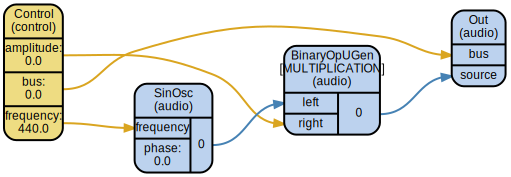

In [59]:
_ = supriya.graph(synthdef)

More ways of "viewing" a SynthDef:

In [60]:
print(str(synthdef))

synthdef:
    name: simple_sine
    ugens:
    -   Control.kr: null
    -   SinOsc.ar:
            frequency: Control.kr[2:frequency]
            phase: 0.0
    -   BinaryOpUGen(MULTIPLICATION).ar:
            left: SinOsc.ar[0]
            right: Control.kr[0:amplitude]
    -   Out.ar:
            bus: Control.kr[1:bus]
            source[0]: BinaryOpUGen(MULTIPLICATION).ar[0]



In [61]:
synthdef.compile()

b'SCgf\x00\x00\x00\x02\x00\x01\x0bsimple_sine\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00C\xdc\x00\x00\x00\x00\x00\x03\tamplitude\x00\x00\x00\x00\x03bus\x00\x00\x00\x01\tfrequency\x00\x00\x00\x02\x00\x00\x00\x04\x07Control\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x01\x01\x01\x06SinOsc\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x00\x02\x0cBinaryOpUGen\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03Out\x02\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00'

### A slightly more complex SynthDef

In [62]:
builder = supriya.SynthDefBuilder(amplitude=1, bus=0, frequency=440, decay_time=5, coefficient=0.1)

In [63]:
with builder:
    envelope = supriya.ugens.EnvGen.kr(
        envelope=supriya.synthdefs.Envelope.linen(
            attack_time=0,
            sustain_time=builder["decay_time"],
            release_time=0,
        ),
        done_action=supriya.DoneAction.FREE_SYNTH,
    )
    source = supriya.ugens.Pluck.ar(
        source=supriya.ugens.WhiteNoise.ar() * builder["amplitude"],
        trigger=supriya.ugens.Impulse.kr(frequency=0),
        maximum_delay_time=0.1,
        delay_time=1 / builder["frequency"],
        decay_time=builder["decay_time"],
        coefficient=builder["coefficient"],
    ) * envelope
    supriya.ugens.Out.ar(bus=builder["bus"], source=[source, source])

SynthDefs do not need to be named. Supriya uses hashing to generate unique names:

In [64]:
pluck_synthdef = builder.build()

In [65]:
pluck_synthdef.name, pluck_synthdef.anonymous_name, pluck_synthdef.actual_name

(None, 'c038313c2faada1b9ffa03fab291a7a1', 'c038313c2faada1b9ffa03fab291a7a1')

In [66]:
server = supriya.Server().boot()
with server.osc_io.capture() as transcript:
    pluck_synthdef.play()

In [67]:
for timestamp, request in transcript.requests:
    print(request)

SynthDefReceiveRequest(
    callback=SynthNewRequest(
        add_action=AddAction.ADD_TO_HEAD,
        node_id=<+ Synth: 1000>,
        synthdef=<SynthDef: c038313c2faada1b9ffa03fab291a7a1>,
        target_node_id=1,
        ),
    synthdefs=(
        <SynthDef: c038313c2faada1b9ffa03fab291a7a1>,
        ),
    )


### A swarm of fretless mandolins

In [68]:
count = 50

with supriya.SynthDefBuilder() as builder:
    frequencies = supriya.ugens.SinOsc.kr(
        frequency=[supriya.ugens.Rand.ir(0.05, 0.2) for _ in range(count)],
        phase=[supriya.ugens.Rand.ir(0., 1.0) for _ in range(count)],
    ).range(1000, 3000)
    plucks = supriya.ugens.Pluck.ar(
        source=[supriya.ugens.WhiteNoise.ar() * 0.1 for _ in range(count)],
        trigger=[supriya.ugens.Impulse.kr(frequency=supriya.ugens.Rand.ir(10, 12)) for _ in range(count)],
        maximum_delay_time=1 / 100,
        delay_time=1 / frequencies,
        decay_time=2,
        coefficient=[supriya.ugens.Rand.ir(0.01, 0.2) for _ in range(count)],
    )
    pans = supriya.ugens.Pan2.ar(
        source=plucks,
        position=[supriya.ugens.Rand.ir(-1, 1) for _ in range(count)]
    )
    mix = supriya.ugens.Mix.multichannel(pans, 2)
    supriya.ugens.Out.ar(source=supriya.ugens.LeakDC.ar(source=mix))

In [69]:
angry_mandolins = builder.build()

This SynthDef is too large to send over UDP:

In [70]:
len(angry_mandolins.compile())

26472

Supriya does the right thing:

In [71]:
with server.osc_io.capture() as transcript:
    synth = angry_mandolins.play()

In [72]:
for timestamp, request in transcript.requests:
    print(request)

SynthDefLoadDirectoryRequest(
    callback=SynthNewRequest(
        add_action=AddAction.ADD_TO_HEAD,
        node_id=<+ Synth: 1001>,
        synthdef=<SynthDef: 793964b200e8e7d05651a861e93ca357>,
        target_node_id=1,
        ),
    directory_path=PosixPath('/var/folders/vf/w6nkg9fj1j5401ft0lzngjwr0000gp/T/tmpgfjjhan3'),
    )


In [73]:
synth.free()

<- Synth: ???>

Let's parameterize those mandolins:

In [74]:
def make_mandolin_synthdef(count=50):
    with supriya.SynthDefBuilder() as builder:
        frequencies = supriya.ugens.SinOsc.kr(
            frequency=[supriya.ugens.Rand.ir(0.05, 0.2) for _ in range(count)],
            phase=[supriya.ugens.Rand.ir(0., 1.0) for _ in range(count)],
        ).range(1000, 3000)
        plucks = supriya.ugens.Pluck.ar(
            source=[supriya.ugens.WhiteNoise.ar() * 0.1 for _ in range(count)],
            trigger=[supriya.ugens.Impulse.kr(frequency=supriya.ugens.Rand.ir(10, 12)) for _ in range(count)],
            maximum_delay_time=1 / 100,
            delay_time=1 / frequencies,
            decay_time=2,
            coefficient=[supriya.ugens.Rand.ir(0.01, 0.2) for _ in range(count)],
        )
        pans = supriya.ugens.Pan2.ar(
            source=plucks,
            position=[supriya.ugens.Rand.ir(-1, 1) for _ in range(count)]
        )
        mix = supriya.ugens.Mix.multichannel(pans, 2)
        supriya.ugens.Out.ar(source=supriya.ugens.LeakDC.ar(source=mix))
    return builder.build()

In [75]:
server.reboot()

<Server: udp://127.0.0.1:57751, 8i8o>

In [77]:
synth_1 = make_mandolin_synthdef(count=1).play()

In [78]:
synth_5 = make_mandolin_synthdef(count=5).play()

In [79]:
synth_25 = make_mandolin_synthdef(count=25).play()

In [80]:
server.quit()

<Server: offline>

## SynthDef Factories

In [81]:
factory = supriya.synthdefs.SynthDefFactory()

In [82]:
def signal_block(builder, source, state):
    iterations = state.get('iterations') or 2
    for _ in range(iterations):
        source = supriya.ugens.AllpassC.ar(
            decay_time=supriya.ugens.ExpRand.ir(0.01, 0.1),
            delay_time=supriya.ugens.ExpRand.ir(0.01, 0.1),
            source=source,
            maximum_delay_time=0.1,
            )
    return source

In [83]:
factory = factory.with_input()
factory = factory.with_output()
factory = factory.with_signal_block(signal_block)

In [84]:
synthdef = factory.build()

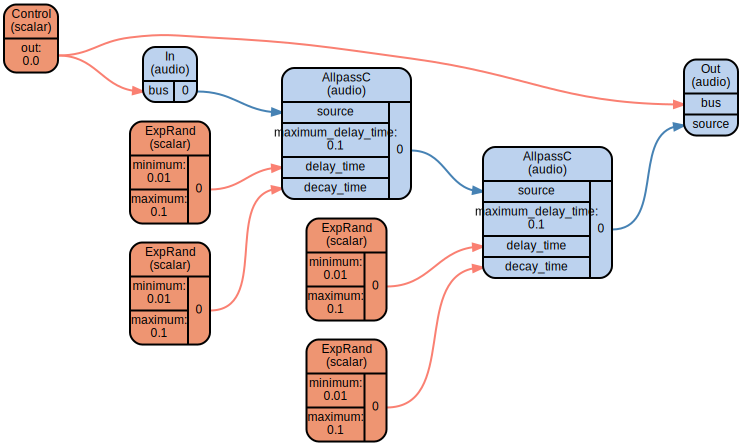

In [85]:
_ = supriya.graph(synthdef)

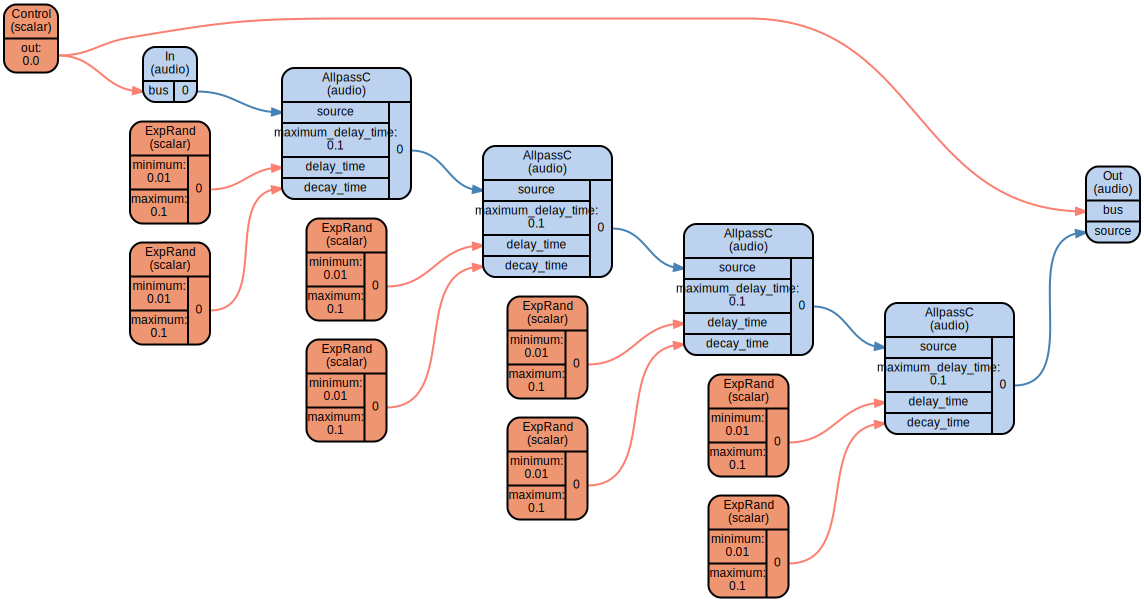

In [86]:
synthdef = factory.build(iterations=4)
_ = supriya.graph(synthdef)

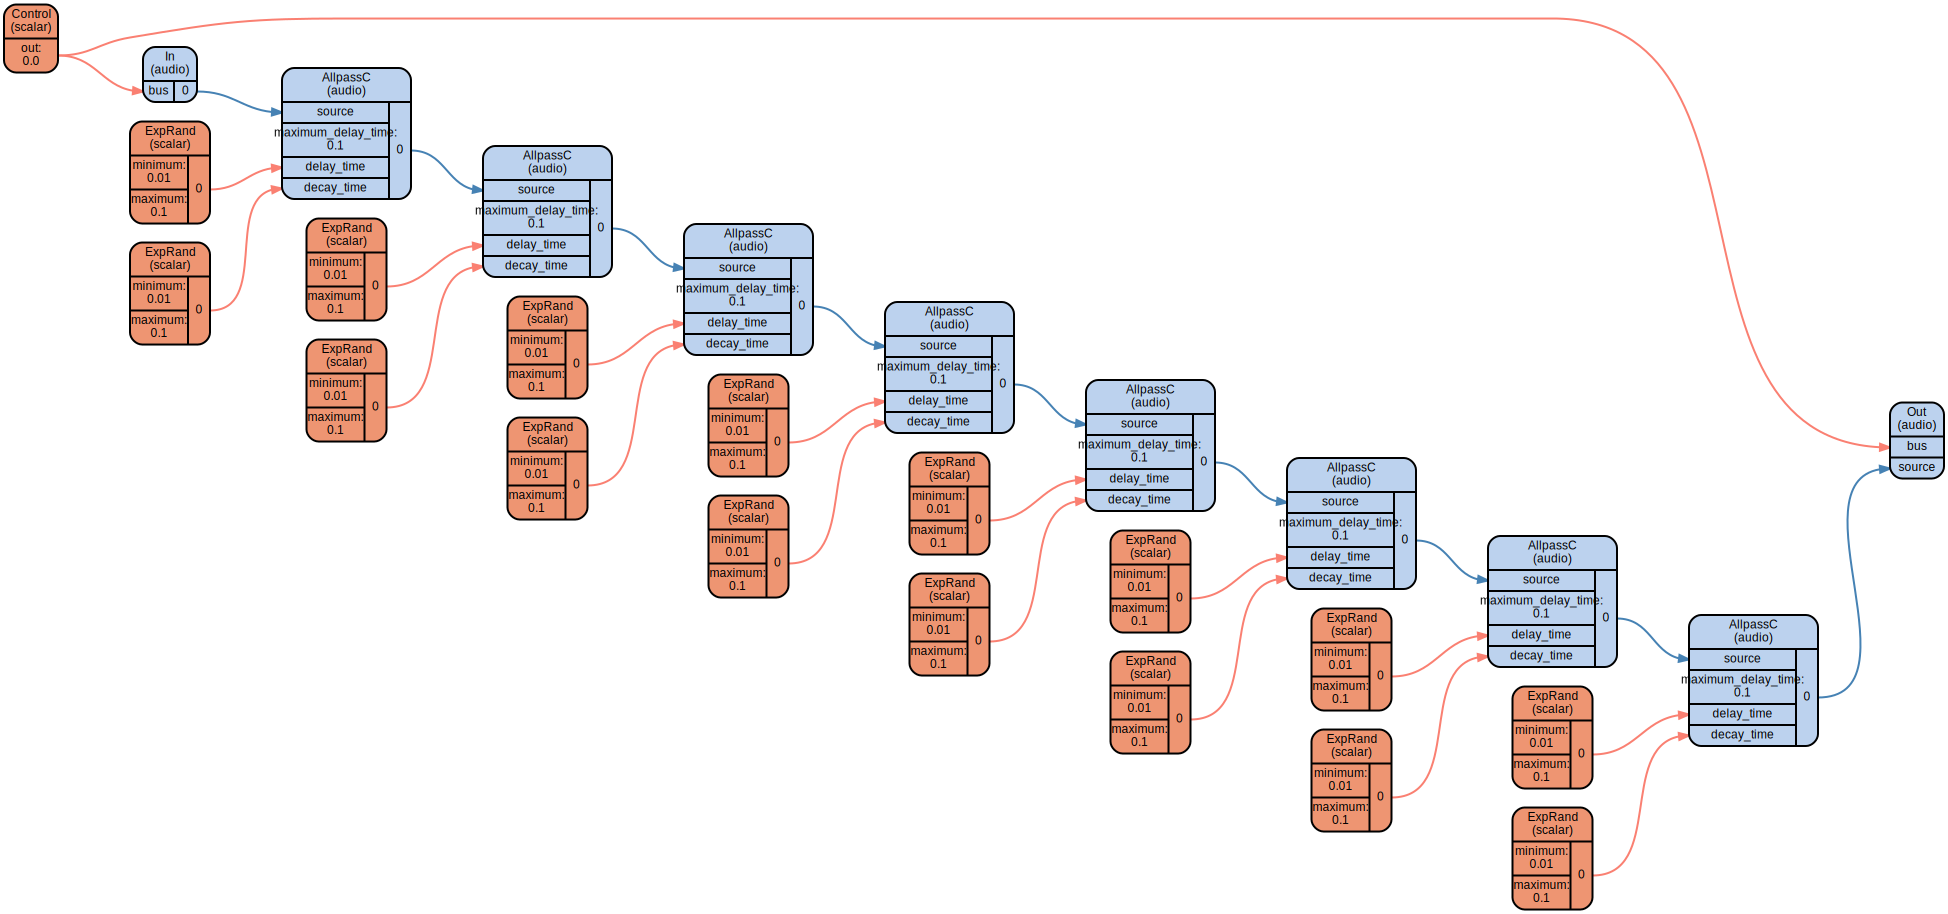

In [87]:
synthdef = factory.build(iterations=8)
_ = supriya.graph(synthdef)

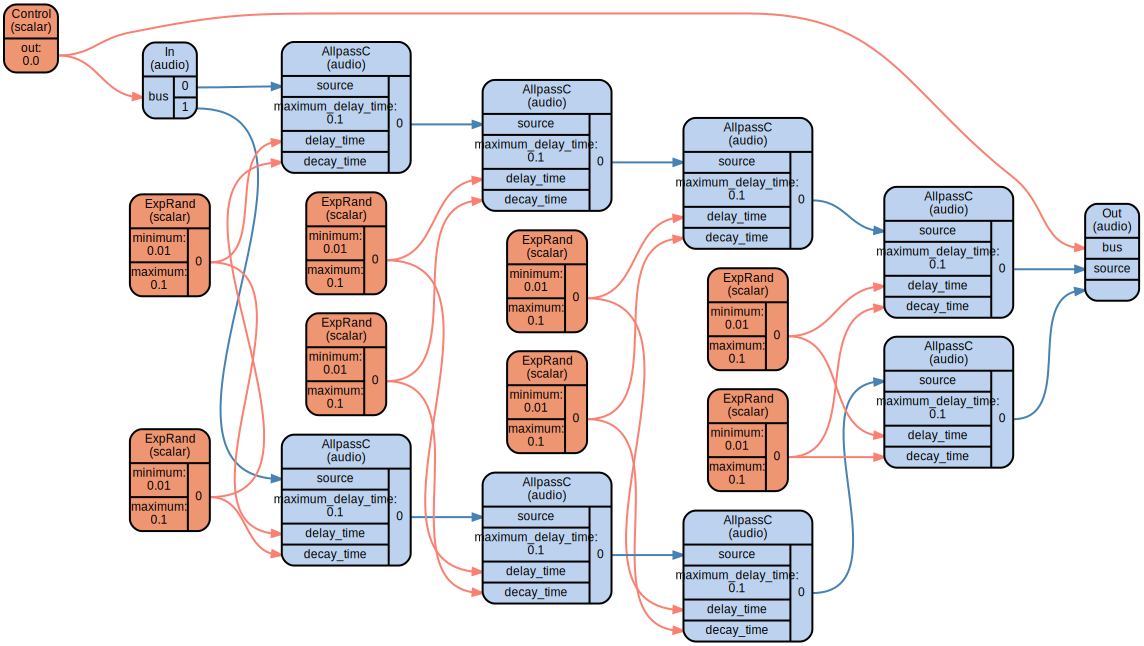

In [88]:
synthdef = factory.build(iterations=4, channel_count=2)
_ = supriya.graph(synthdef)

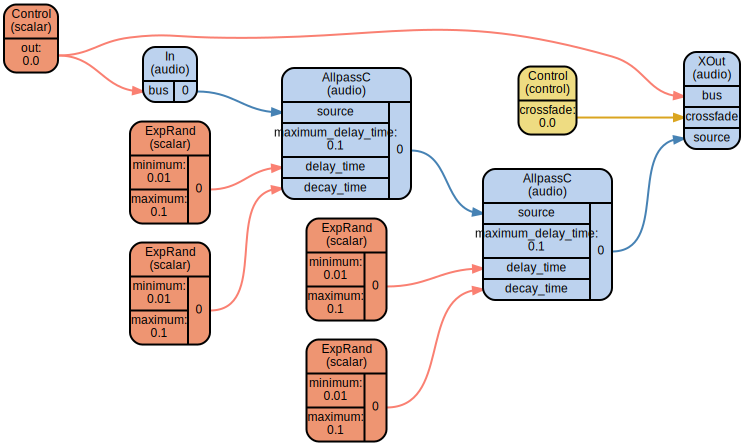

In [89]:
factory = factory.with_output(crossfaded=True)
synthdef = factory.build(iterations=2)
_ = supriya.graph(synthdef)

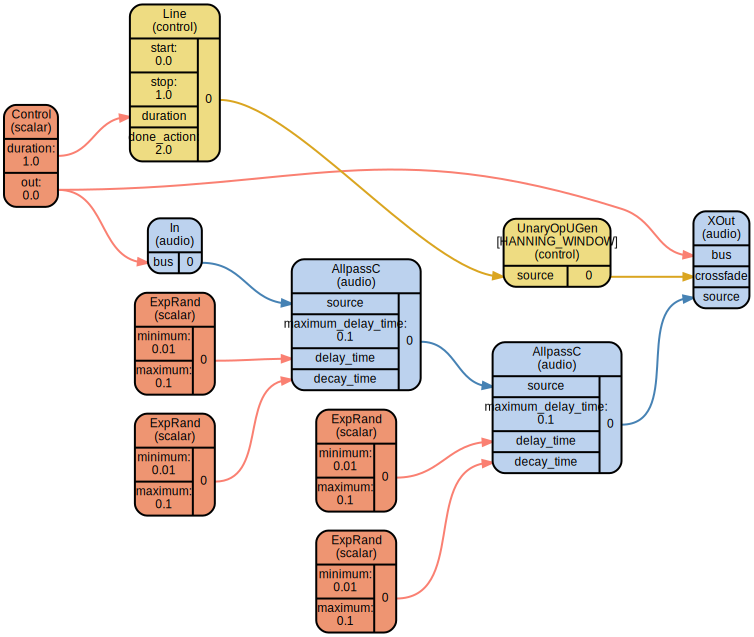

In [90]:
factory = factory.with_output(crossfaded=True, windowed=True)
synthdef = factory.build(iterations=2)
_ = supriya.graph(synthdef)

In [91]:
def signal_block_post(builder, source, state):
    source = supriya.ugens.LeakDC.ar(source=source)
    source = supriya.ugens.Limiter.ar(duration=0.01, source=source)
    return source

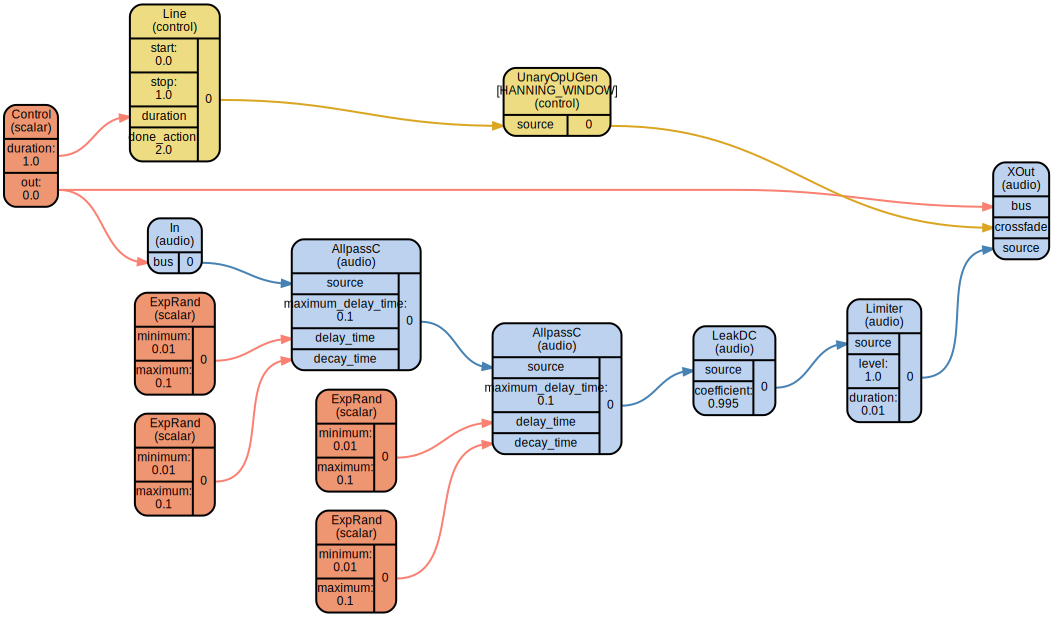

In [92]:
factory = factory.with_signal_block(signal_block_post)
synthdef = factory.build(iterations=2)
_ = supriya.graph(synthdef)

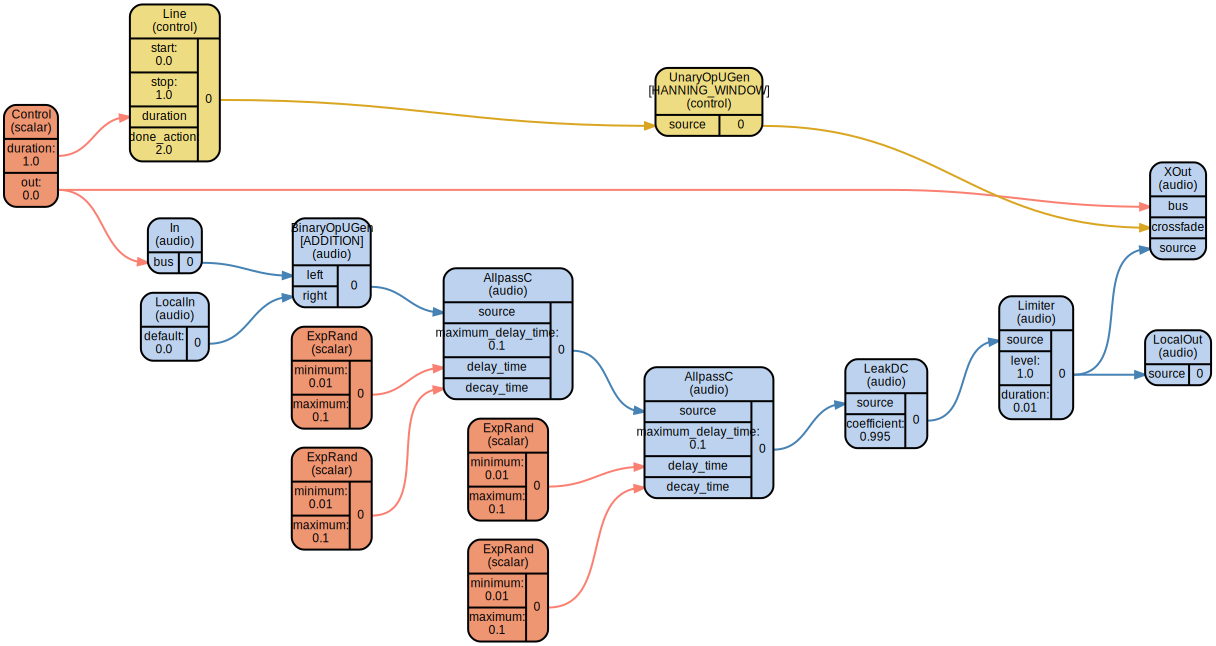

In [93]:
factory = factory.with_feedback_loop()
synthdef = factory.build(iterations=2)
_ = supriya.graph(synthdef)

In [94]:
def feedback_block(builder, source, state):
    return source * supriya.ugens.LFDNoise1.kr(frequency=0.3)

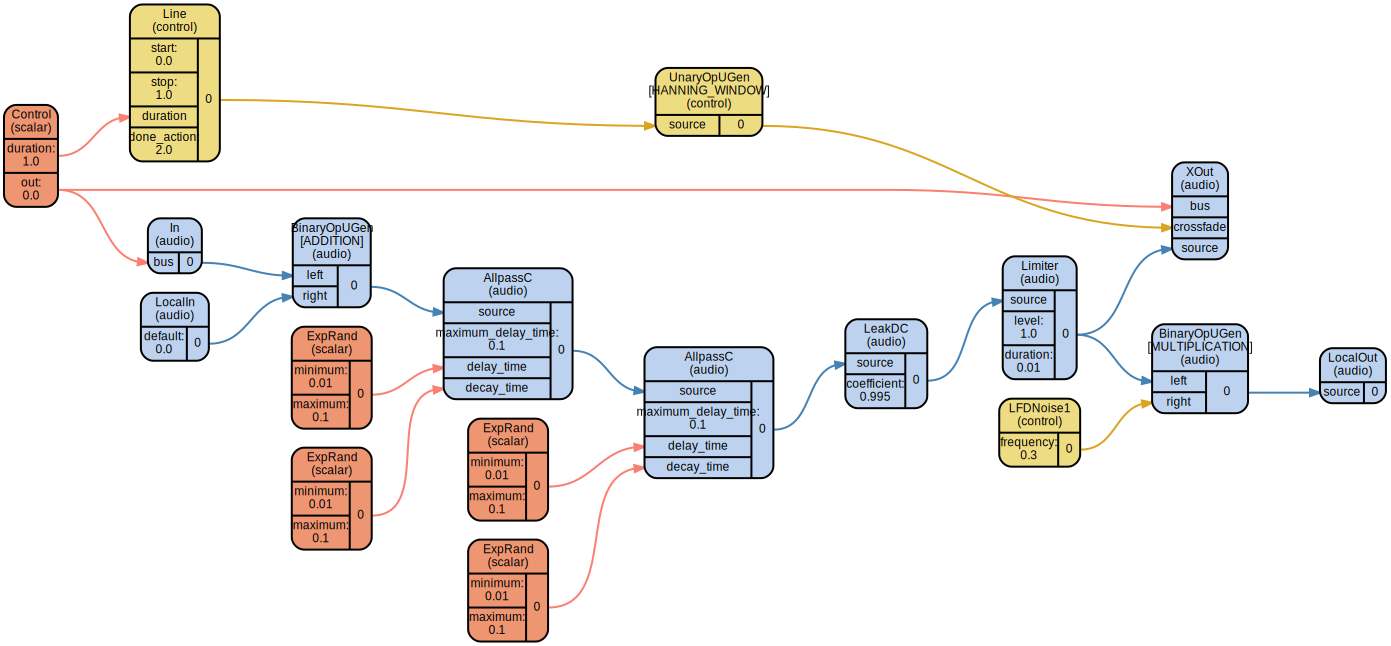

In [95]:
factory = factory.with_feedback_loop(feedback_block)
synthdef = factory.build(iterations=2)
_ = supriya.graph(synthdef)

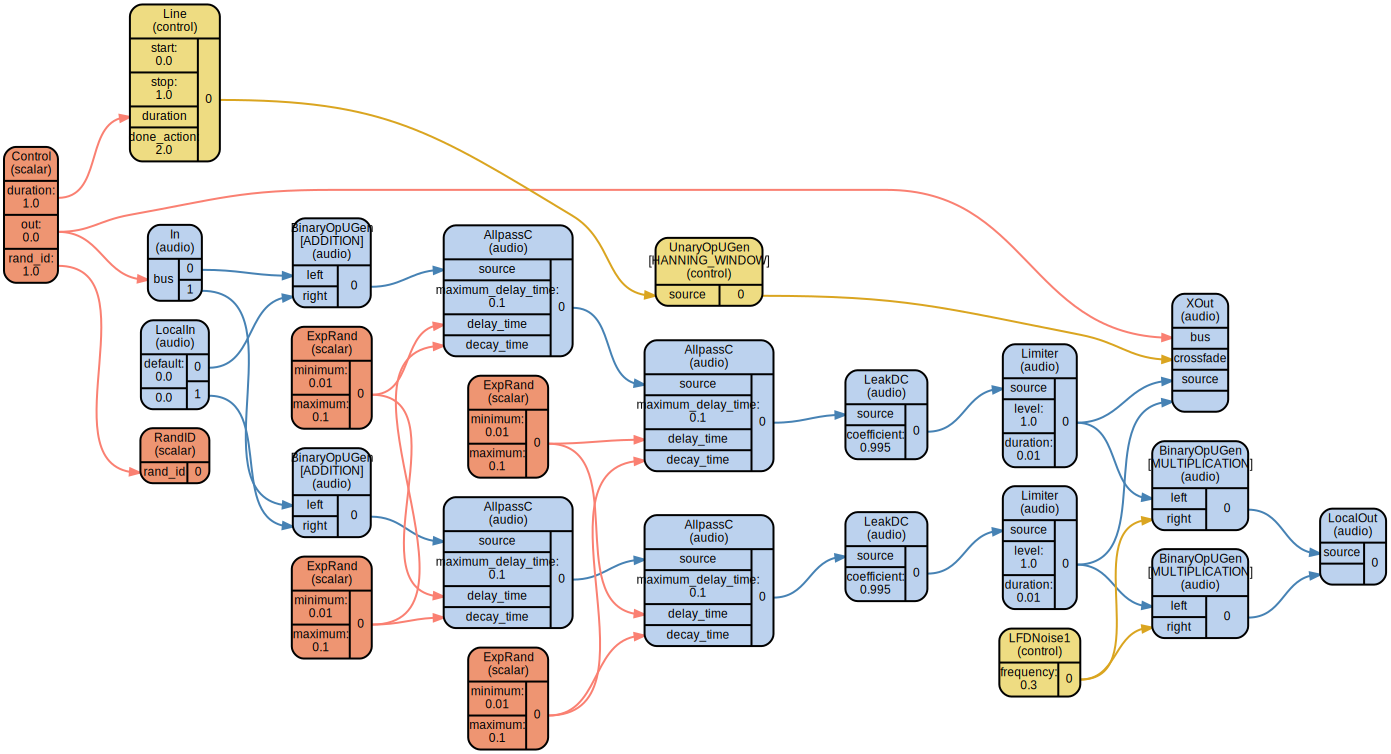

In [96]:
factory = factory.with_rand_id(1)
synthdef = factory.build(iterations=2, channel_count=2)
_ = supriya.graph(synthdef)

## Non-realtime Session Model

### The `__render__` protocol

### NRT Dependency Tree (turtles all the way down)

### (N)RT Patterns

## CLI Tooling and NRT Projects

In [97]:
server.quit()